<h1>Прогнозирование с помощью нейронной сети по данным meteo.ru</h1></br>

<h3>Импорт модулей и библиотек</h3>

In [61]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [62]:
import keras
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

<p>Проверяем версии модулей:</p>

In [63]:
tf.__version__

'1.15.0'

In [64]:
keras.__version__

'2.2.4'

<h3>Импорт данных</h3>

In [65]:
%%time
dataset = pd.read_csv('wr26290a1_fix.csv', parse_dates = ['datetime'])
dataset = dataset.set_index('datetime')

Wall time: 8.02 s


In [66]:
dataset.head(7)

,Общее количество облачности,Количество облачности нижнего яруса,Форма облаков верхнего яруса,Форма облаков среднего яруса,Форма облаков вертикального развития,Слоистые и слоисто-кучевые облака,Слоисто-дожд разорванно-дождевые облака,Погода между сроками,Погода в срок наблюдения,Направление ветра,...,Мин.температура воздуха между сроками,Макс. темперура воздуха между сроками,Парциальное давление водяного пара,Относительная влажность воздуха,Дефицит насыщения водяного пара,Температура точки росы,Атмосферное давление на уровне станции,Атмосферное давление на уровне моря,Характеристика барической тенденции,Величина барической тенденции
datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,10,10,8,8,2,0,3,8,85,210,...,-10.4,-10.0,2.54,89,0.28,-11.5,1005.9,1024.2,2,0.5
2009-01-01 03:00:00,10,10,8,8,2,0,3,8,85,230,...,-10.3,-10.0,2.52,89,0.28,-11.6,1006.6,1025.0,2,0.7
2009-01-01 06:00:00,10,10,8,8,2,0,3,8,85,200,...,-10.3,-9.3,2.60,88,0.35,-11.2,1008.2,1026.5,2,1.6
2009-01-01 09:00:00,10,6,8,2,2,0,3,8,85,230,...,-9.6,-9.3,2.53,85,0.45,-11.6,1009.2,1027.6,2,1.0
2009-01-01 12:00:00,10,10,8,8,0,4,0,8,2,220,...,-9.7,-9.3,2.48,85,0.45,-11.8,1009.9,1028.3,2,0.7
2009-01-01 15:00:00,10,10,8,8,0,4,0,2,2,220,...,-9.7,-9.2,2.34,79,0.64,-12.5,1010.2,1028.6,2,0.3
2009-01-01 18:00:00,10,10,8,8,2,2,0,8,85,230,...,-9.5,-9.1,2.27,76,0.73,-12.9,1011.2,1029.6,2,1.0


In [67]:
print('Размеры таблицы: {}'.format(dataset.shape))

Размеры таблицы: (29213, 24)


<h3>Отсутствующие и номинальные данные</h3>

In [68]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29213 entries, 2009-01-01 00:00:00 to 2018-12-31 12:00:00
Data columns (total 24 columns):
Общее количество облачности                 29213 non-null int64
Количество облачности нижнего яруса         29213 non-null int64
Форма облаков верхнего яруса                29213 non-null int64
Форма облаков среднего яруса                29213 non-null int64
Форма облаков вертикального развития        29213 non-null int64
Слоистые и слоисто-кучевые облака           29213 non-null int64
Слоисто-дожд  разорванно-дождевые облака    29213 non-null int64
Погода между сроками                        29213 non-null int64
Погода в срок наблюдения                    29213 non-null int64
Направление ветра                           29213 non-null int64
Средняя скорость ветра                      29213 non-null int64
Максимальная скорость ветра                 29213 non-null int64
Сумма осадков                               29213 non-null float64
Температу

In [69]:
columns = dataset.columns
print('Итог: {} столбцов.'.format(len(columns)))

Итог: 24 столбцов.


<b>Отрисовка на графиках показателей для идентификации данных </b></br>

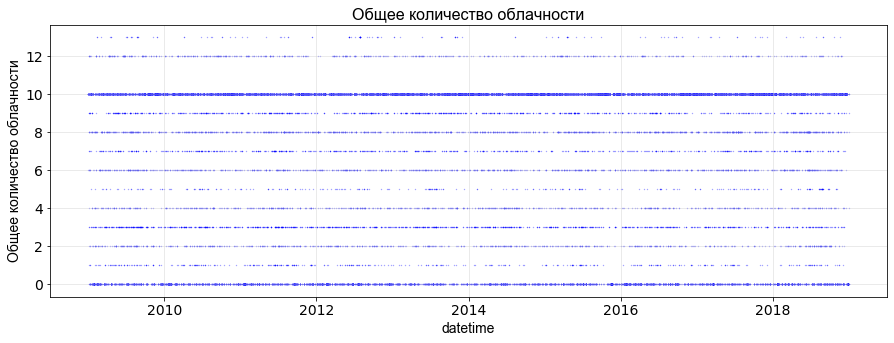

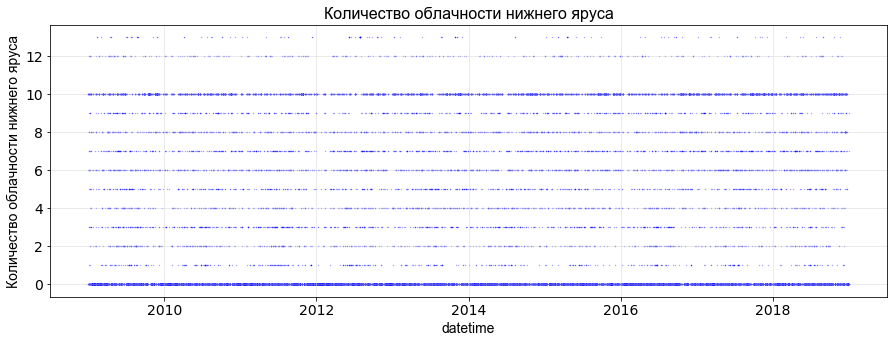

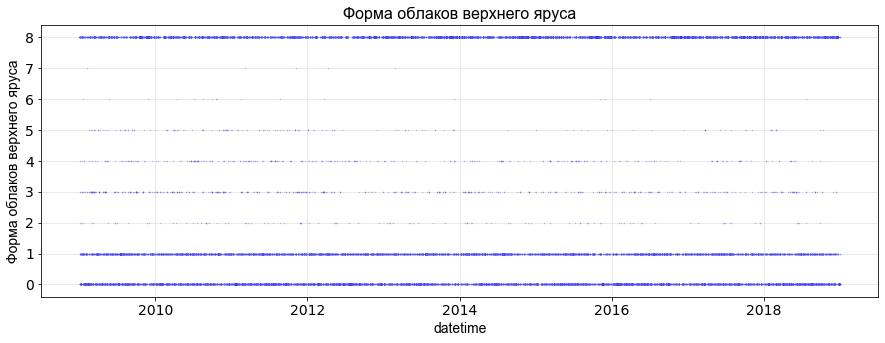

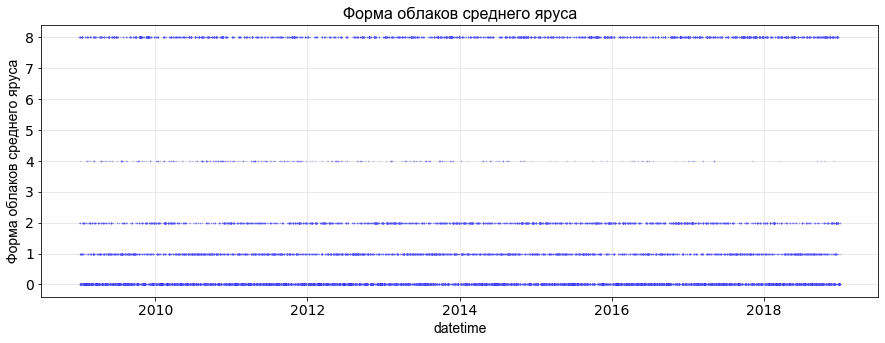

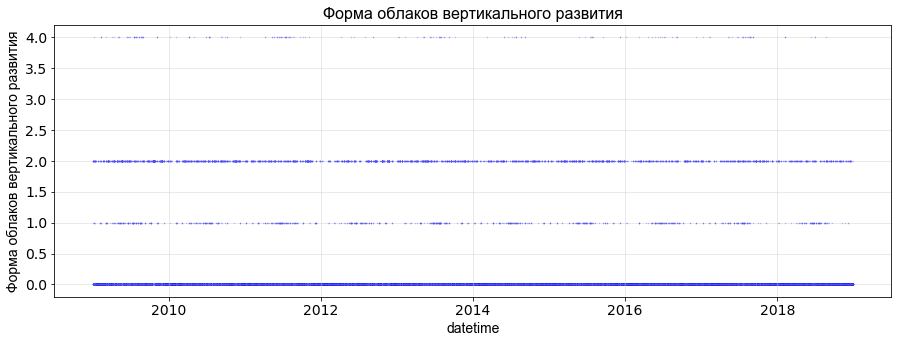

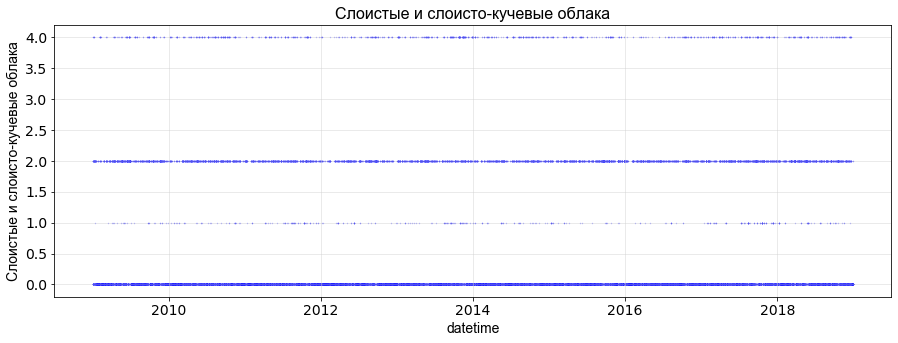

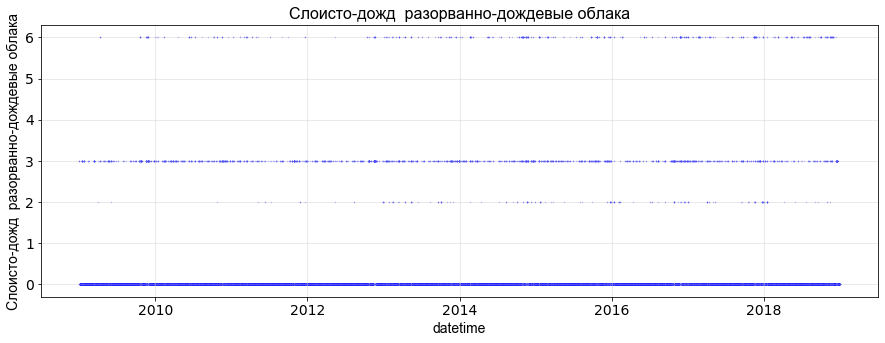

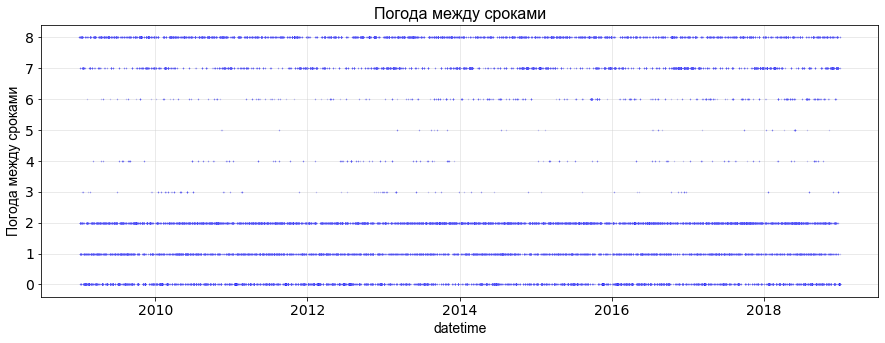

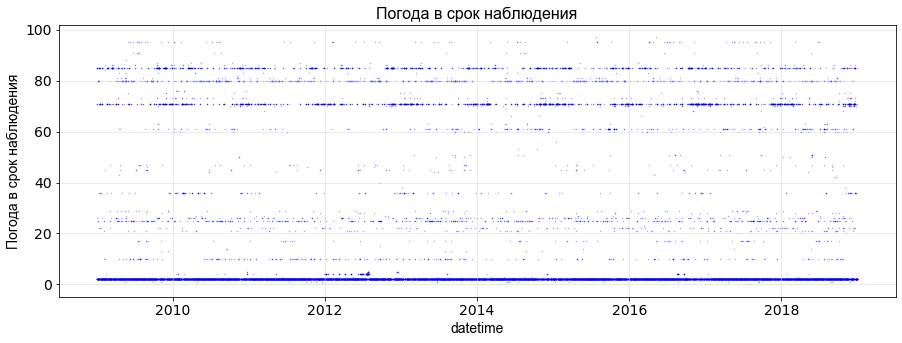

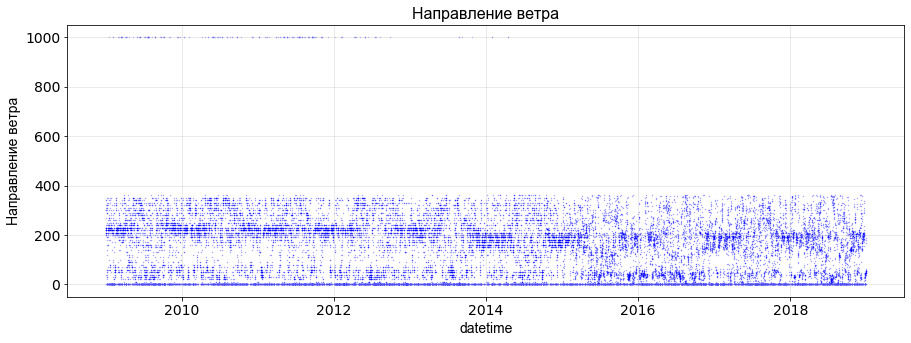

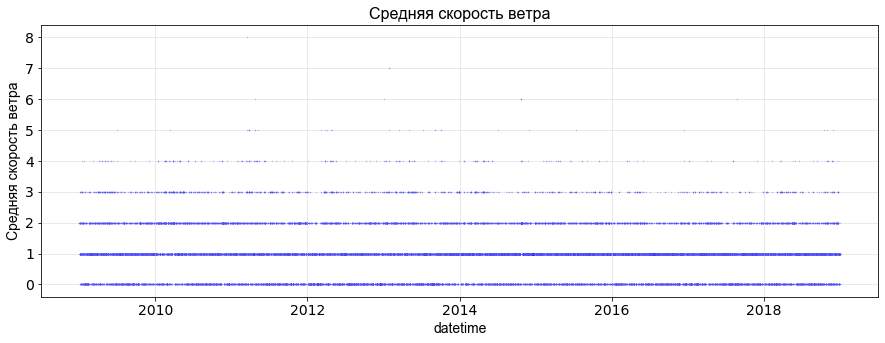

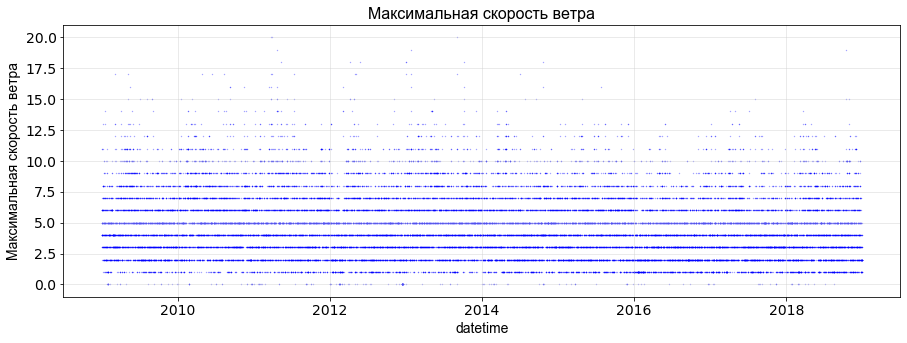

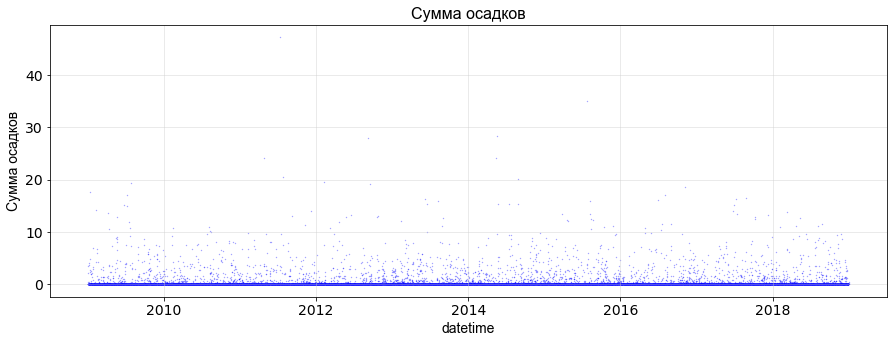

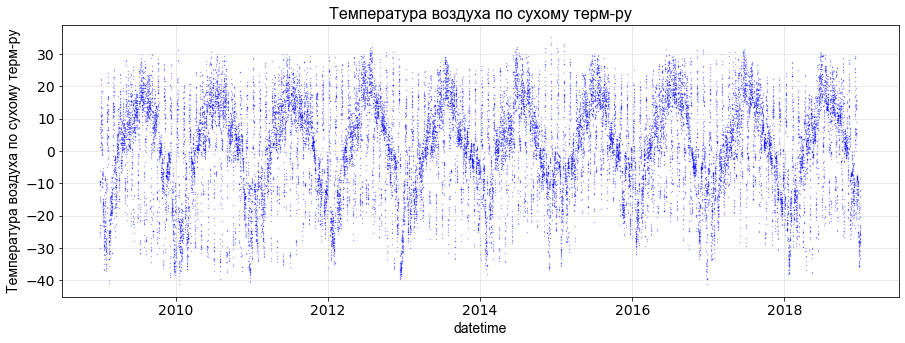

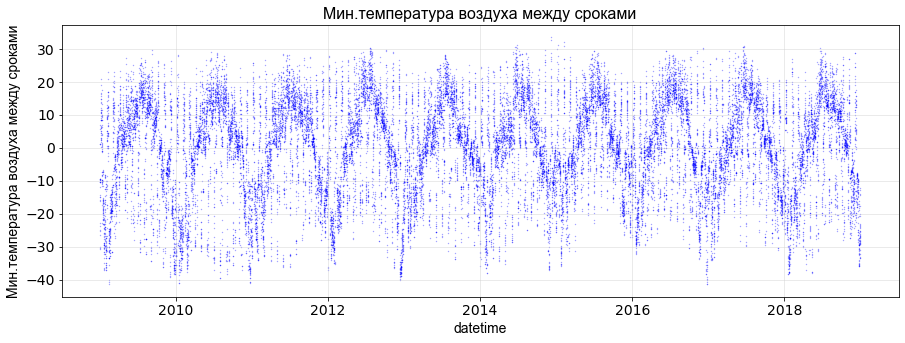

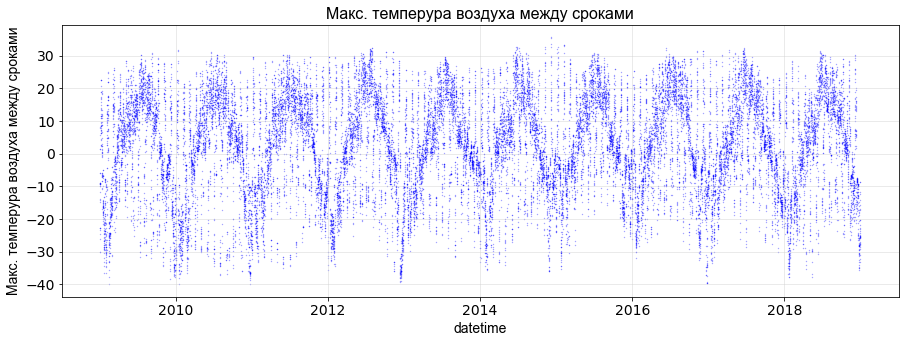

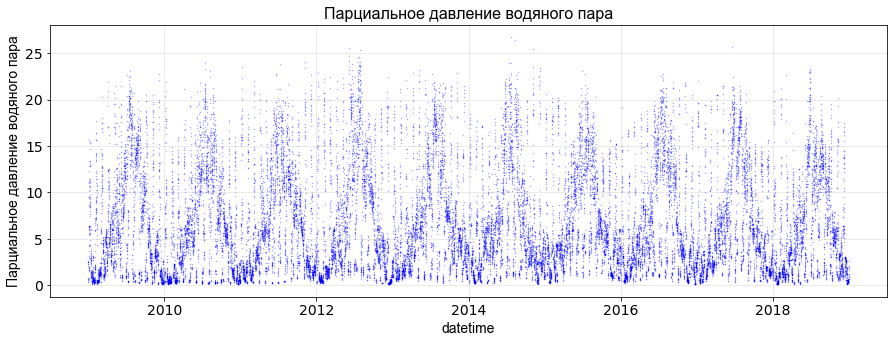

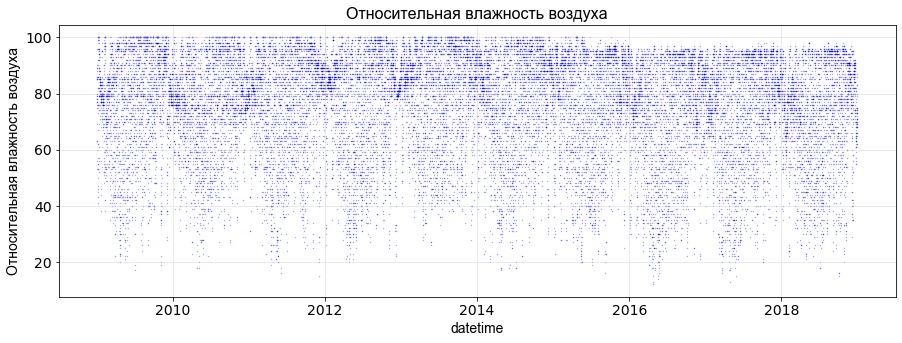

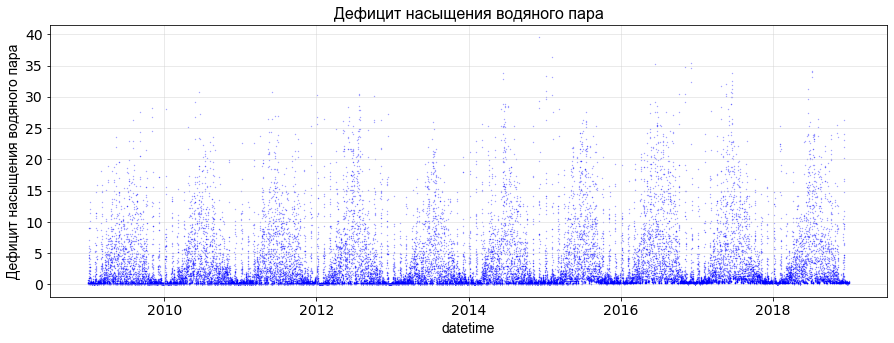

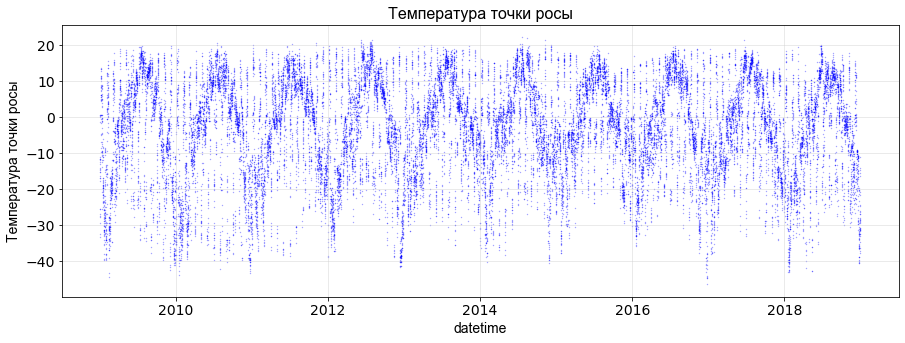

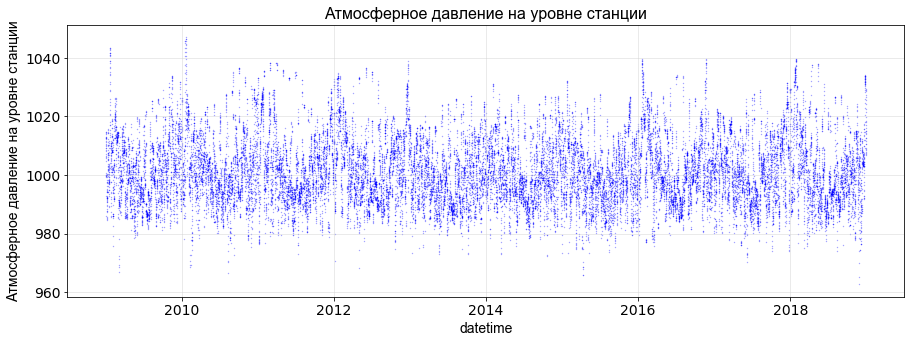

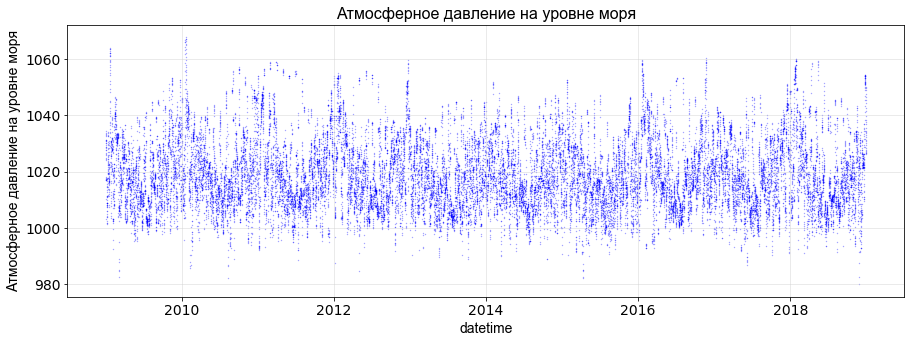

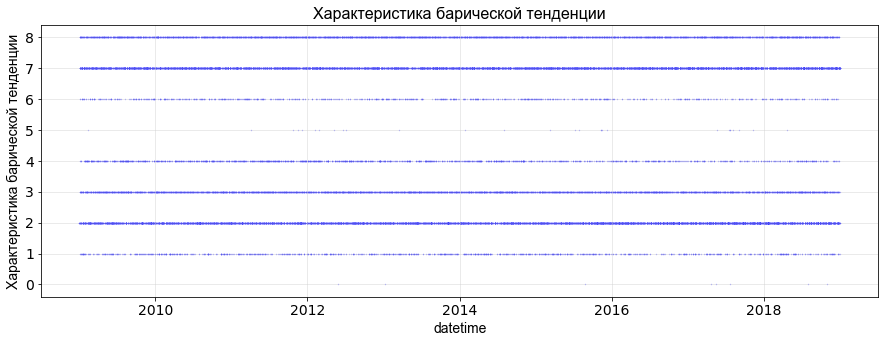

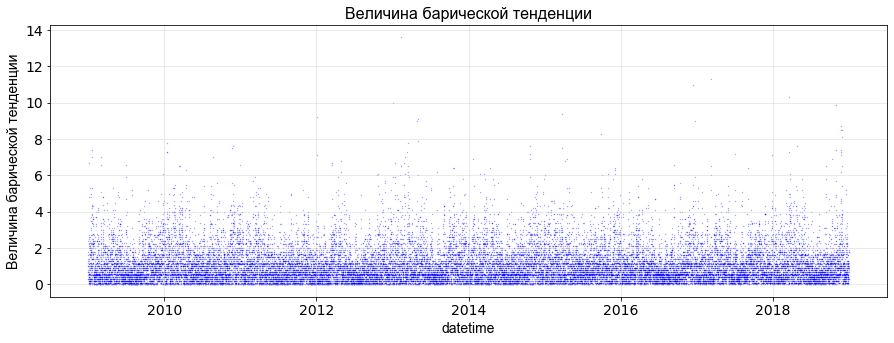

Wall time: 19.4 s


In [70]:
%%time

def plotTimeSeries(dataset, feature_name):
    _ = plt.rcParams['figure.figsize'] = (15, 5)
    _ = plt.grid(which = 'major', c = '#cccccc', alpha = 0.5)
    _ = plt.scatter(dataset.index, dataset[feature_name],
                    marker = 'o', s = 0.1, alpha = 0.5,
                    color = 'blue')
    _ = plt.title(feature_name, family = 'Arial', fontsize = 16)
    _ = plt.xlabel('datetime', family = 'Arial', fontsize = 14)
    _ = plt.ylabel(feature_name, family = 'Arial', fontsize = 14)
    _ = plt.xticks(fontsize = 14)
    _ = plt.yticks(fontsize = 14)
    _ = plt.show()
                  
    return None
    
for feature in columns:
    plotTimeSeries(dataset, feature)
    

<h3>Целевые данные для прогнозирования</h3>
<p>Предсказание сигналов.</p>

In [71]:
target_features = [
    'Температура воздуха по сухому терм-ру', 
    'Относительная влажность воздуха', 
    'Максимальная скорость ветра', 
    'Атмосферное давление на уровне станции', 
]

print('Мы будем прогнозировать {} признака.'.format(len(target_features)))

Мы будем прогнозировать 4 признака.


<p>Далее - число шагов времени, на это число сдвинем целевые данные. Выборка дескретизирована на наблюдения каждые <b>3 часа</b>, так что <code>8</code> наблюдений на каждые 24 часа</p></br>
<p>Если нужно спрогнозировать погоду на <b>7</b> дней вперёд, смещение на <code>7 × 8 = 56</code> шагов времени.</p>

In [72]:
shift_days = 7
shift_steps = shift_days * 8

In [73]:
df_targets = dataset[target_features].shift(-shift_steps)
df_targets.head(5)

,Температура воздуха по сухому терм-ру,Относительная влажность воздуха,Максимальная скорость ветра,Атмосферное давление на уровне станции
datetime,,,,
2009-01-01 00:00:00,-8.1,87.0,7.0,999.6
2009-01-01 03:00:00,-7.7,96.0,4.0,1000.9
2009-01-01 06:00:00,-7.0,91.0,4.0,1004.0
2009-01-01 09:00:00,-9.1,79.0,8.0,1008.9
2009-01-01 12:00:00,-14.0,84.0,6.0,1014.1


In [74]:
df_targets.tail()

,Температура воздуха по сухому терм-ру,Относительная влажность воздуха,Максимальная скорость ветра,Атмосферное давление на уровне станции
datetime,,,,
2018-12-31 00:00:00,NaN,NaN,NaN,NaN
2018-12-31 03:00:00,NaN,NaN,NaN,NaN
2018-12-31 06:00:00,NaN,NaN,NaN,NaN
2018-12-31 09:00:00,NaN,NaN,NaN,NaN
2018-12-31 12:00:00,NaN,NaN,NaN,NaN


<h3>Реализуем смещения в выборках (NumPy Arrays)</h3>

<p>Чтобы работать с данными, конвертируем выборки (DataFrame) Pandas в массивы (array) NumPy, которые могут быть входными сигналами для нейронной сети.</p></br>
<p>Это <b>входные сигналы.</b></p>

In [75]:
x_data = dataset.values[0:-shift_steps]

print(type(x_data))
print('Размер: {}'.format(x_data.shape))

<class 'numpy.ndarray'>
Размер: (29157, 24)


<p>Это <b>выходные сигналы</b> (или <b>целевые сигналы</b>).</p>

In [76]:
y_data = df_targets.values[:-shift_steps]
print('Размер: {}'.format(y_data.shape))

Размер: (29157, 4)


In [77]:
# Число наблюдений
num_data = len(x_data)
print(num_data)

29157


<h3>Построение учебного набора данных и тестового набора</h3>

<b>Учебный набор:</b>

In [78]:
train_split = 0.9

num_train = int(train_split * num_data)
print('Длина учебного набора: {} наблюдений.'.format(num_train))

Длина учебного набора: 26241 наблюдений.


<b>Тестовый набор:</b>

In [79]:
num_test = num_data - num_train
print('Длина тестового набора: {} наблюдений.'.format(num_test))

Длина тестового набора: 2916 наблюдений.


<b>Проверка:</b>

Входные сигналы для учебного набора и тестовый набор:

In [80]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(len(x_train) + len(x_test))

29157


Выходные сигналы для учебного набора и тестовый набор:

In [81]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(len(y_train) + len(y_test))

29157


<p>Число входных сигналов:</p>

In [82]:
num_x_signals = x_data.shape[1]
num_x_signals

24

<p>Число выходных сигналов:</p>

In [83]:
num_y_signals = y_data.shape[1]
num_y_signals

4

<h3>Масштабирование данных</h3>
<p>Данные содержат широкий диапазон значений, так что должны быть отмасштабированы для использования.</p>

In [84]:
print('Min значение: {}'.format(np.min(x_train)))
print('Max значение: {}'.format(np.max(x_train)))

Min значение: -46.4
Max значение: 1067.7


<p>ИНС работает лучше всего на значениях между <code>-1</code> и <code>1</code>, поэтому отмасштабируем данные перед запуском сети,используя библиотеку<code>scikit-learn</code> и модель<code>MinMaxScaler</code> для этого.</p>

In [85]:
# Определяем объект Scaler
x_scaler = MinMaxScaler()

In [86]:
# Используем объект для учебных данных
x_train_scaled = x_scaler.fit_transform(x_train)

# всех данных
x_data_scaled = x_scaler.fit_transform(dataset.values)

<p>Исключая небольшую ошибку округления, данные отмасштабированны между <code>0</code> и <code>1</code>.</p>

In [87]:
print('Min значение {}'.format(np.min(x_train_scaled)))
print('Max значение {}'.format(np.max(x_train_scaled)))

Min значение 0.0
Max значение 1.0000000000000002


In [88]:
# Используем объект Scaler для тестовых данных
x_test_scaled = x_scaler.transform(x_test)

In [89]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

<h3>Генератор данных</h3>
<p>Выборка теперь подготовлена как двухмерный массив (array) Numpy. Учебные данные - примерно 26 тыс. наблюдений, состоящие из 24 входных и 4 выходных сигнала.</p></br>
<p>Это входные и выходные данные в форме массива:</p>

In [90]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(26241, 24)
(26241, 4)


<p>Вместо обучения рекуррентной нейронной сети на полной последовательности из прибл. 26 тыс. наблюдений, используем следующую функцию для создания группы более коротких последовательностей, взятых произвольно из учебных данных.</p>

In [91]:
def batch_generator(batch_size, sequence_length):
    
    while True:
        # Создаём новый массив для группы входных сигналов
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape = x_shape, dtype = np.float16)
        
        # Создаём новый массив для группы выходных сигналов
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape = y_shape, dtype = np.float16)
        
        # заполняем группу произвольными последовательностями данных
        for i in range(batch_size):
            # Получаем произвольный начальный индекс в учебных данных
            idx = np.random.randint(num_train - sequence_length)
            
            # Копируем последовательность данных от этого индекса
            x_batch[i] = x_train_scaled[idx : idx + sequence_length]
            y_batch[i] = y_train_scaled[idx : idx + sequence_length]
        
        # возвращаем генератор
        yield(x_batch, y_batch)

In [92]:
batch_size = 64

<p>Используем длину последовательности <b>720</b>, что значит каждая произвольная последовательность включает наблюдения за <b>3</b> месяца. Один шаг времени - 3 часа, значит <code>8</code> - 1 день, и <code>8*30</code> - 1 месяц.</p>

In [93]:
sequence_length = 8 * 30 * 3
print('Длина последовательности {} наблюдений.'.format(sequence_length))

Длина последовательности 720 наблюдений.


<p>Создаём генератор групп:</p>

In [94]:
generator = batch_generator(batch_size = batch_size,
                            sequence_length = sequence_length)

<h3>Набор для проверки</h3>

<p>Нейронная сеть учится быстро, поэтому можно запустить много обучающих эпох. Но есть риск <b><i>переобучения</i></b> модели учебным набором так, что оно не обучится хорошо на незнакомых данных.</p></br>
<p>Поэтому будем проверять производительность модели на тестовом наборе после каждой эпохи и сохранять веса только если производительность улучшилась.</p></br>

In [95]:
validation_data = (np.expand_dims(x_test_scaled, axis = 0),
                   np.expand_dims(y_test_scaled, axis = 0))
                  
print(validation_data)
print('Длина данных проверки: {}'.format(len(validation_data[0][0])))

(array([[[0.76923077, 0.        , 1.        , ..., 0.32915718,
         1.        , 0.27205882],
        [0.76923077, 0.76923077, 1.        , ..., 0.29157175,
         0.875     , 0.22058824],
        [0.76923077, 0.76923077, 1.        , ..., 0.261959  ,
         0.875     , 0.18382353],
        ...,
        [0.        , 0.        , 0.        , ..., 0.79384966,
         0.125     , 0.07352941],
        [0.        , 0.        , 0.        , ..., 0.79840547,
         0.25      , 0.04411765],
        [0.        , 0.        , 0.        , ..., 0.81321185,
         0.25      , 0.08823529]]]), array([[[0.29281046, 0.80681818, 0.1       , 0.7755857 ],
        [0.3254902 , 0.84090909, 0.15      , 0.76942047],
        [0.34117647, 0.85227273, 0.2       , 0.76942047],
        ...,
        [0.4248366 , 0.80681818, 0.15      , 0.57459926],
        [0.38169935, 0.77272727, 0.15      , 0.59802713],
        [0.35816993, 0.84090909, 0.2       , 0.60665845]]]))
Длина данных проверки: 2916


<h2>Создание рекуррентной нейронной сети</h2>
<p>Используем библиотеку для глубокого машинного обучения <i>Keras API</i>.</p>

In [96]:
model = Sequential()

<p>Добавим управляемый рекуррентный блок (Gated Recurrent Unit, GRU) в сеть. У него будет 64 выходов для каждого шага времени в последовательности.</p></b>
<p>Это первый слой модели, Keras должен знать форму входных данных, которая - группа последовательностей произвольной длины (указано как <code>None</code>), где каждое наблюдение имеет определённое число входных сигналов (<code>num_x_signals</code>).</p>

In [97]:
model.add(GRU(units = 64,
              return_sequences = True,
              input_shape = (None, num_x_signals,)))

<p><i>GRU</i> отдаёт группу последовательностей с 64-мя значениями. Для предсказания 4 выходных сигналов добавляем полностью соединённый (или плотный) слой Dense, который приводит <b>64</b> значений к <b>4</b>-м.</p></br>
<p>Выходные сигналы в наборе данных были ограничены значениям между <code>0</code> и <code>1</code> используя объект Scaler. Так что также ограничиваем вывод ИНС используя лог-сигмоидную функцию активации, которая выдаёт значение между <code>0</code> и <code>1</code>.</p>

In [98]:
model.add(Dense(num_y_signals, activation = 'sigmoid'))

<h3>Обучение на основе коррекции ошибок. Функция потерь</h3></br>
<p>Будем использовать средний квадрат отклонения (Mean Squared Error, <b>MSE</b>) как функцию потерь, которая будет минимизироваться. Это измерит, как близко вывод модели соответствует настоящим выходным сигналам. Пошаговая корректировка весов нейрона продолжается, до тех пор пока нейрон не достигнет устойчивого состояния, тоесть такого, при котором веса практически не меняются.</p></br>

<p>Однако, в начале последовательности, модель НС видит только входные сигналы для немногих шагов времени, так что этот расчитанный вывод может быть очень неточным. Используя значение потери для ранних временных шагов может вызвать искажение последующих результатов моделью. Следовательно дадим модели ИНС <i>период разогрева</i> в 50 шагов времени, где не используем точность в функции потерь, предполагая улучшение точности в последующих шагах времени.</p>

In [99]:
warmup_steps = 50

In [100]:
def loss_mse_warmup(y_true, y_pred):
    
    # игнорируем части последовательностей для "разогрева"
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
      
    # вычислим MSE потерю для каждого значения в этих тензорах.
    loss = tf.losses.mean_squared_error(labels = y_true_slice,
                                        predictions = y_pred_slice)
    
    # используем потерю через весь тензор, чтобы уменьшить до единственного среднего значения.
    loss_mean = tf.reduce_mean(loss)
    
    return loss_mean

<h3>Компилируем модель</h3>
<p>Это оптимизатор и начальный коэффициент скорости обучения.</p>

In [101]:
optimizer = RMSprop(lr = 1e-3)

<p>Компилируем модель Keras, так что она готова для обучения.</p>

In [102]:
model.compile(loss = loss_mse_warmup, optimizer = optimizer, metrics=['accuracy'])

In [103]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 64)          17088     
_________________________________________________________________
dense_2 (Dense)              (None, None, 4)           260       
Total params: 17,348
Trainable params: 17,348
Non-trainable params: 0
_________________________________________________________________


<h3>Функции обратного вызова</h3>
<p>В течение обучения делаем сохранения и ведем лог прогресса TensorBoard, для этого создаём необходимые функции обратного вызова для Keras. 
Это функция для записи сохранения в процессе обучения.</p>

In [104]:
path_checkpoint = "./checkpoints/{epoch:02d}_wl_{val_loss:.2f}.keras"
callback_checkpoint = ModelCheckpoint(filepath = path_checkpoint,
                                      monitor = 'val_loss',
                                      verbose = 1,
                                      save_weights_only = True,
                                      save_best_only = True)

<p>Это функция для остановки оптимизации, когда производительность ухудшается на <code>наборе для проверки</code>.</p>

In [105]:
callback_early_stopping = EarlyStopping(monitor = 'val_loss',
                                        patience = 5,
                                        verbose = 1)

In [106]:
callback_tensorboard = TensorBoard(log_dir = './23_logs/',
                                   histogram_freq = 0,
                                   write_graph = False)

<p>Это ф-ция обратного вызова, которая уменьшает коэффициент скорости обучения для оптимизатора, если потеря не улучшилась за прошедшую эпоху (как отмечено через <code>patience = 0</code>. Коэфф. скорости обучения будет уменьшен умножением на данный  фактор. Укажем начальный коэфф. выше <code>1e-3</code>, так что умножая на <code>0.1</code> даёт <code>1e-4</code>. Коэфф. не будет ниже этого значения.</p>

In [107]:
callback_reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                       factor = 0.1,
                                       min_lr = 1e-4,
                                       patience = 0,
                                       verbose = 1)

In [108]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr,
             callback_tensorboard]

<h2>Обучение рекуррентной НС</h2>

<p><code>Эпоха</code> не соответствует единственной обработке учебного набора, потому что генератор групп произвольно выбирает под-последовательности из учебного набора. Вместо этого выбираем <code>steps_per_epoch</code> </p>

Для целей обучения и из-за причины, что используется CPU (не GPU), выставляем намного более низкие параметры:
<ul>>> <code>epochs = 25</code></ul>
<ul>>> <code>steps_per_epoch = 25</code></ul></p>
<p>Это<code>25 × 25 = <b>625</b></code> наблюдений.</p>

In [109]:
%%time
model.fit_generator(generator = generator,
                    epochs = 25,
                    steps_per_epoch = 25,
                    initial_epoch = 0,
                    validation_data = validation_data,
                    callbacks = callbacks)





Epoch 1/25
25/25 [==============================] - 60s 2s/step - loss: 0.0292 - acc: 0.6321 - val_loss: 0.0223 - val_acc: 0.6564

Epoch 00001: val_loss improved from inf to 0.02230, saving model to ./checkpoints/01_wl_0.02.keras

Epoch 2/25
25/25 [==============================] - 63s 3s/step - loss: 0.0203 - acc: 0.6846 - val_loss: 0.0203 - val_acc: 0.6722

Epoch 00002: val_loss improved from 0.02230 to 0.02030, saving model to ./checkpoints/02_wl_0.02.keras
Epoch 3/25
25/25 [==============================] - 58s 2s/step - loss: 0.0197 - acc: 0.6890 - val_loss: 0.0201 - val_acc: 0.6766

Epoch 00003: val_loss improved from 0.02030 to 0.02013, saving model to ./checkpoints/03_wl_0.02.keras
Epoch 4/25
25/25 [==============================] - 44s 2s/step - loss: 0.0190 - acc: 0.6984 - val_loss: 0.0193 - val_acc: 0.6842

Epoch 00004: val_loss improved from 0.02013 to 0.01935, saving model to ./checkpoints/04_wl_0.02.keras
Epoch 5/25
25/25 [==============================] - 46s 2s/step

<h3>Загружаем контрольную точку</h3>
<p>Когда обучаем модель НС, возможно, что производительность ухудшилась на тестовом наборе за несколько эпох прежде остановки. Так что загрузим сохранение, в котором лучшая производительность на тестовом наборе.</p>

In [ ]:
try:
    model.load_weights("./checkpoints/25_wl_0.02.keras")
except Exception as error:
    print('Ошибка при попытке загрузить контрольную точку.\n{}'.format(error))

<h2>Производительность на тестовом наборе</h2>
<p>Теперь можно оценить производительность модели на тестовом наборе.</p>

In [110]:
result, accuracy = model.evaluate(x = np.expand_dims(x_test_scaled, axis = 0), y = np.expand_dims(y_test_scaled, axis = 0))
print('Потеря (тестовый набор): {}'.format(result))
print('Точность (тестовый набор): {}'.format(accuracy))

1/1 [==============================] - 0s 439ms/step
Потеря (тестовый набор): 0.01788819581270218
Точность (тестовый набор): 0.7235939502716064


<h2>Общий прогноз</h2>

<p>Функция рисует предсказанные и настоящие сигналы.</p>

In [111]:
def plot_comparison(start_idx, length = 100, train = True):
      
    if train == True:
        # Использовать данные обучения
        x = x_train_scaled
        y_true = y_train
    
    elif train == False:
        # Использовать тестовые данные
        x = x_test_scaled
        y_true = y_test
    
    else:
        # Использовать любые данные
        x = x_data_scaled
        y_true = y_data
        
        
    # Конечный индекс последовательности.
    end_idx = start_idx + length
    
    # Берём последовательность от начального индекса
    # и заданной длины.
    x = x[start_idx:end_idx]
    
    y_true = y_true[start_idx:end_idx]
    
    # Входные сигналы модели.
    x = np.expand_dims(x, axis = 0)
    
    # Используем модель, чтобы предсказать выходной сигнал.
    y_pred = model.predict(x)
    
    # Выход модели между 0 и 1.
    # Делаем обратное масштабирование к значениям
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_features)):
        
        # Получить выходной сигнал модели.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Получить настоящий выходной сигнал.
        signal_true = y_true[:, signal]
        
        # Делаем холст для графика.
        plt.figure(figsize = (15, 5))
        
        # Рисуем и сравниваем два сигнала.
        plt.plot(signal_true, label = 'True', color = 'green')
        plt.plot(signal_pred, label = 'Pred.', color = 'blue')
        
        # Рисуем серую область для периода "прогрева".
        p = plt.axvspan(0, warmup_steps, facecolor = 'black', alpha = 0.15)
        
        # Рисуем обозначения
        plt.ylabel(target_features[signal], fontsize = 14)
        plt.legend(loc = 'best', shadow = True)
        plt.show()
        
    return None

<p>Запустим с примером из обучающих данных. Это данные, которые модель видела в процессе обучения, так что должна предсказывать достаточно неплохо.</p>

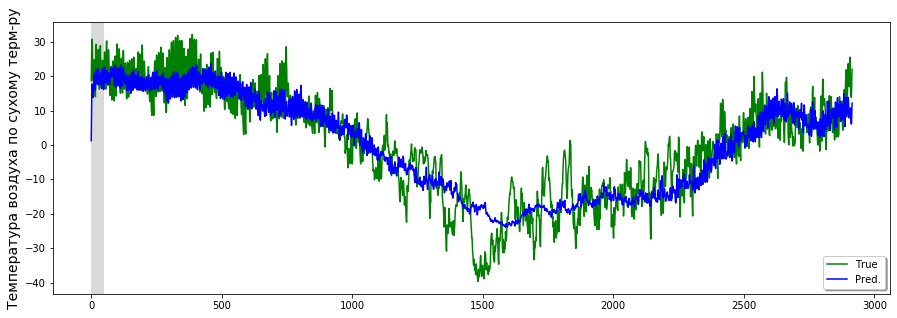

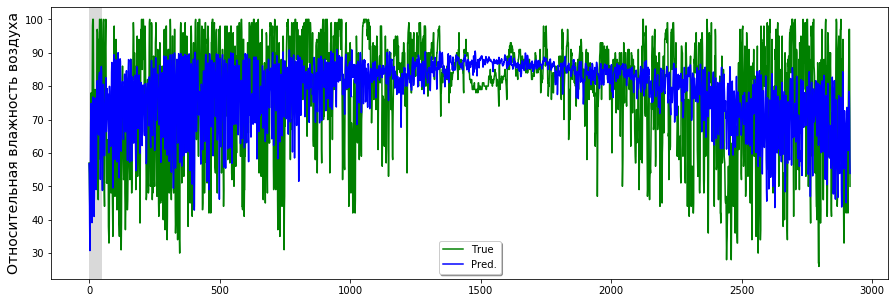

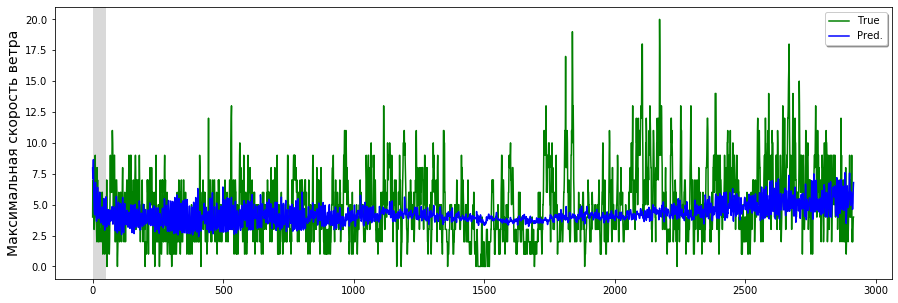

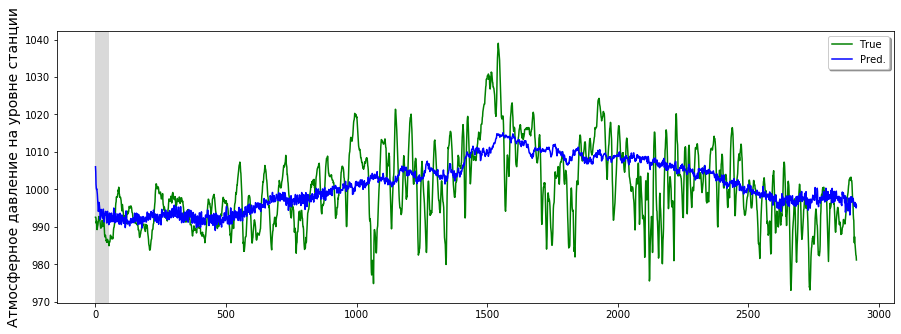

In [112]:
plot_comparison(start_idx = 10000, length = 2916, train = True)

<h3>Пример из тестового набора</h3>
<p>Теперь рассмотрим пример из тестового набора. Модель не видела этих данных в процессе обучения.</p>

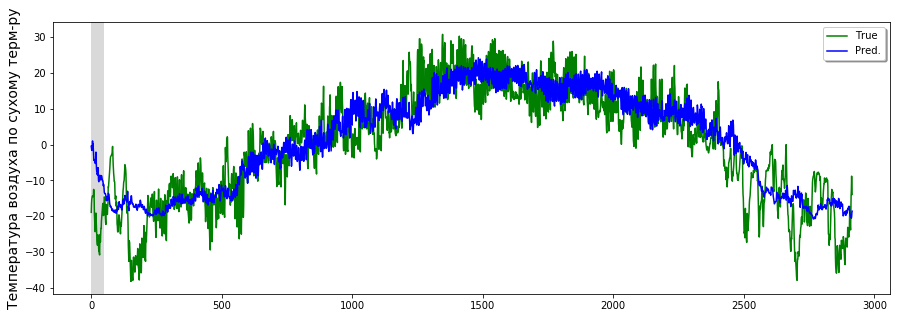

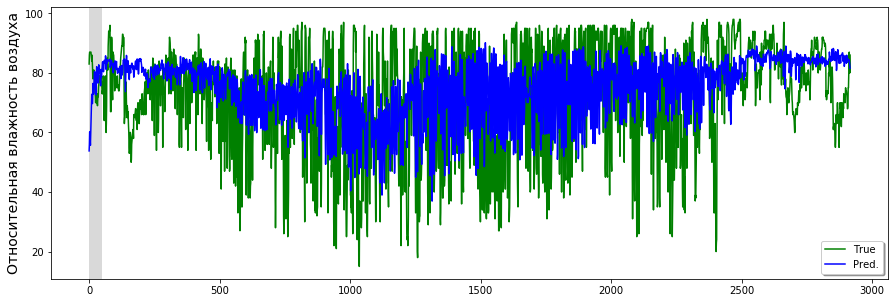

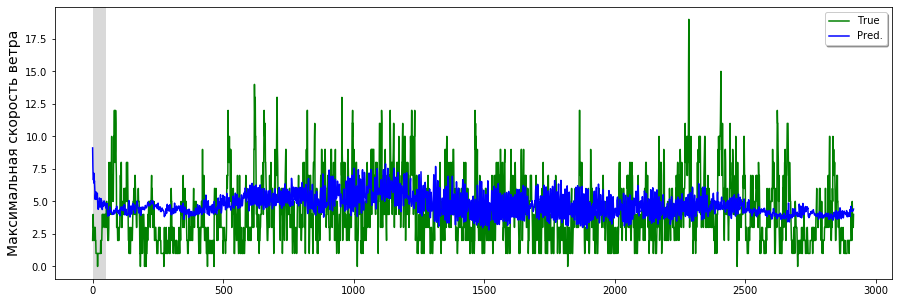

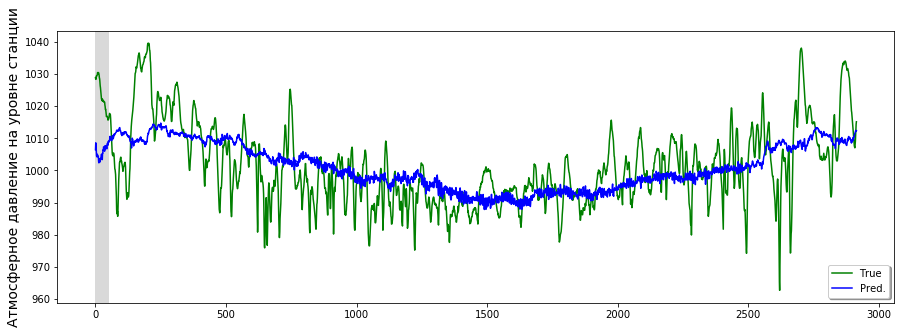

In [113]:
plot_comparison(start_idx = 0, length = 2916, train = False)

А теперь попробуем предсказать на 7 дней.

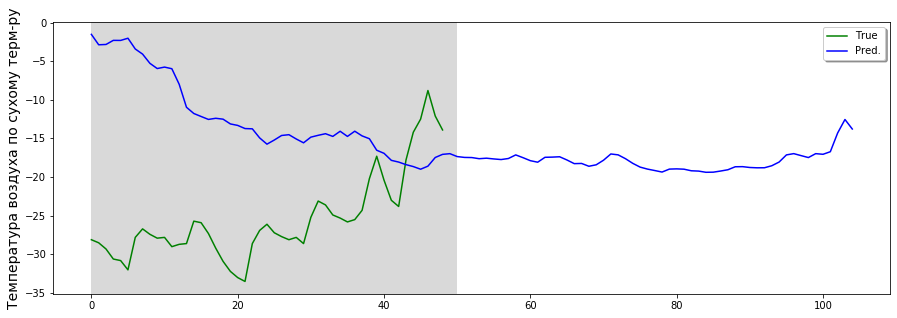

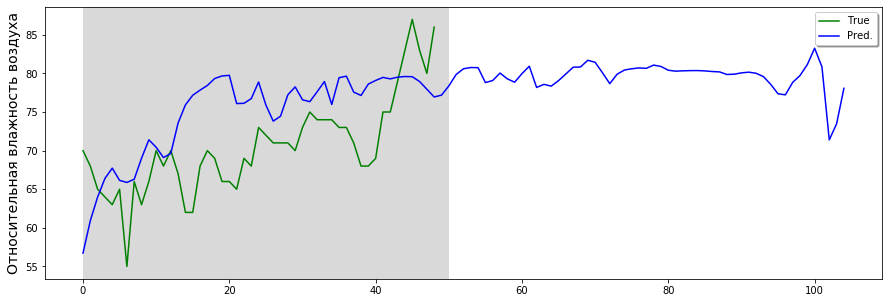

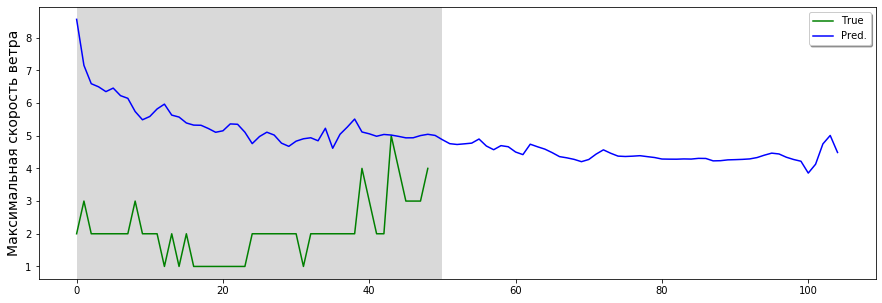

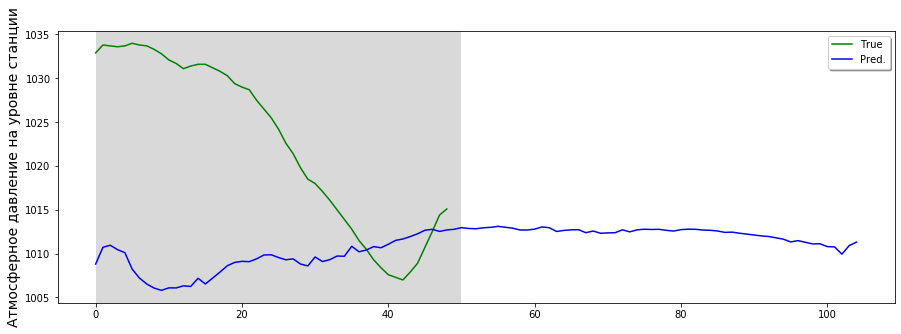

In [114]:
pred_idx = 29158 - warmup_steps
pred_length = warmup_steps + shift_steps
plot_comparison(start_idx = pred_idx, length = pred_length, train = None)